# Homework 2

## Import packages and data

Import necessary packages.

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import math

import wrds
import fredapi

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.formula.api import ols
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from matplotlib import pyplot as plt

Import data from WRDS: S&P 500 returns, dividends, levels.

In [2]:
wrds_conn = wrds.Connection(wrds_username='wmann')
data = wrds_conn.raw_sql("select caldt, vwretd, vwretx, spindx, totval from crsp_a_indexes.msp500")
wrds_conn.close() 

data['month'] = pd.to_datetime(data['caldt']).dt.to_period('M')
data = data.set_index(['month']).drop('caldt',axis=1)

# Calculate S&P 500 dividends as the difference between monthly return with and without dividends.
data['dividends_mth'] = ( data['vwretd'] - data['vwretx'] )*data['spindx'].shift()

# Aggregate dataset to quarterly level.
dataq = data.reset_index()
dataq['quarter'] = dataq['month'].dt.to_timestamp().dt.to_period('Q')
dataq = dataq.set_index('quarter')
dataq['dividends_qtr'] = dataq.groupby(level=0)['dividends_mth'].sum()
dataq = dataq.groupby(level=0).last()

# dataq = dataq['1926Q1':]
dataq = dataq['2004':]

Loading library list...
Done


Calculate the series that we will actually use in the analysis

In [3]:
log_spindx = np.log(dataq['spindx'])
log_spindx_growth = log_spindx.diff().dropna()

log_dividends = np.log(dataq['dividends_qtr'])
log_dividends_growth = log_dividends.diff().dropna()

log_DP = np.log(dataq['dividends_qtr']/dataq['spindx'])

## Assignment

The code above calculates five different series, at a quarterly frequency, from 2000 to the present:
1. The S&P 500 index level, measured as a logarithm.
2. The change in the above value (that is, the percentage increase in the S&P 500 index).
3. The dividends paid by S&P 500 stocks, as a logarithm.
4. The change in the above value (that is, the percentage growth of S&P 500 dividend payments).
5. The S&P 500 dividend yield (dividends as a fraction of index value), as a logarithm.

For each of the above series, plot them, and then conduct an ADF test and a KPSS test (allowing statsmodels to choose the optimal number of lags). What, if anything, do these tests tell you about whether it is appropriate to model the series as stationary?

Finally, for the ADF test that you ran in #3 above (the log of dividends paid), show how the test statistic from this test can be located in the output from a regression, using the statsmodels summary() command. Then explain why the p-value from the test cannot be located anywhere in the same regression output.

## Solution

#### 1. Level of S&P 500 index

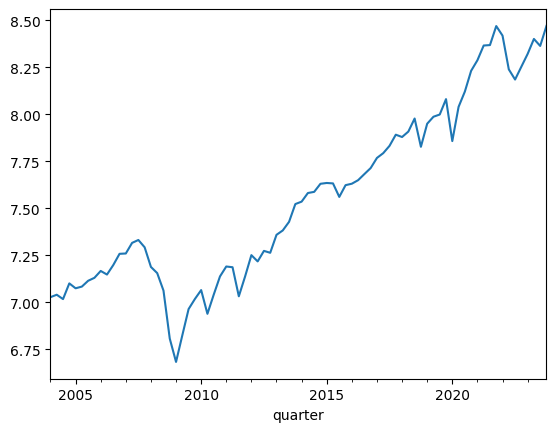

In [4]:
log_spindx.plot();

In [5]:
adfuller( log_spindx )

(0.07034607559300295,
 0.9639771837892123,
 0,
 79,
 {'1%': -3.5159766913976376,
  '5%': -2.898885703483903,
  '10%': -2.5866935058484217},
 -133.459509136088)

In [6]:
kpss( log_spindx )

/tmp/ipykernel_754836/1594106753.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss( log_spindx )


(1.315567879109731,
 0.01,
 5,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Conclusion: Both tests suggest that it would be **inappropriate** to model this as a stationary series.

#### 2. Growth rate of S&P 500 index

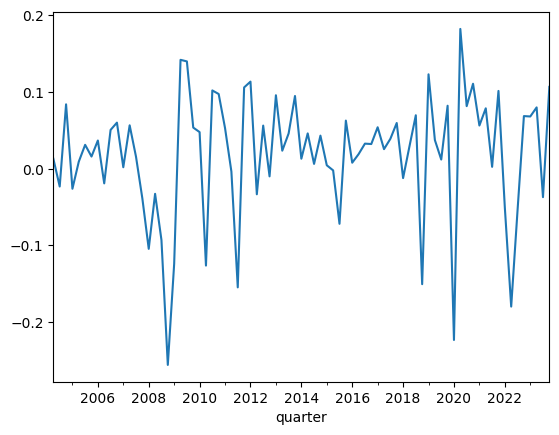

In [7]:
log_spindx_growth.plot();

In [8]:
adfuller( log_spindx_growth )

(-8.338274434467614,
 3.227742314582285e-13,
 0,
 78,
 {'1%': -3.517113604831504,
  '5%': -2.8993754262546574,
  '10%': -2.5869547797501644},
 -130.77731752341097)

In [9]:
kpss( log_spindx_growth )

/tmp/ipykernel_754836/667722974.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss( log_spindx_growth )


(0.13691838750205632,
 0.1,
 0,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Conclusion: Both tests suggest that it would be **appropriate** to model this as a stationary series.

#### 3. Level of S&P 500 dividends

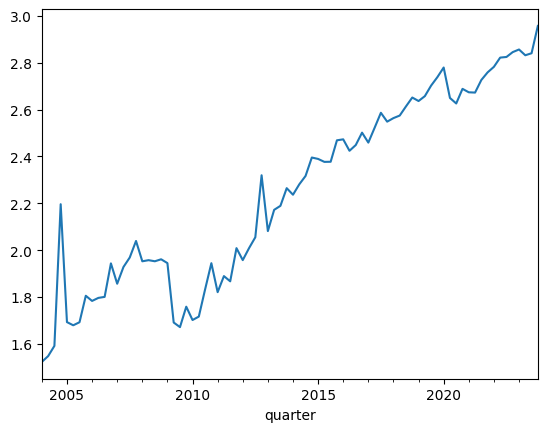

In [10]:
log_dividends.plot();

In [11]:
adfuller( log_dividends )

(-0.011293297591935309,
 0.9575881137795227,
 4,
 75,
 {'1%': -3.520713130074074,
  '5%': -2.9009249540740742,
  '10%': -2.5877813777777776},
 -160.5636169925196)

In [12]:
kpss( log_dividends )

/tmp/ipykernel_754836/92200752.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss( log_dividends )


(1.3945620187152263,
 0.01,
 5,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Conclusion: Both tests suggest that it would be **inappropriate** to model this as a stationary series.

#### 4. Growth rate of S&P 500 dividends

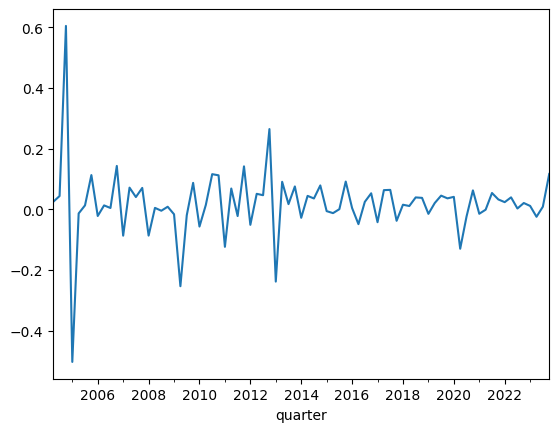

In [13]:
log_dividends_growth.plot();

In [14]:
adfuller( log_dividends_growth )

(-4.5493474429220395,
 0.00015997799470014878,
 3,
 75,
 {'1%': -3.520713130074074,
  '5%': -2.9009249540740742,
  '10%': -2.5877813777777776},
 -159.3558377039773)

In [15]:
kpss( log_dividends_growth )

/tmp/ipykernel_754836/3168183638.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss( log_dividends_growth )


(0.08455593196895585,
 0.1,
 16,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Conclusion: Both tests suggest that it would be **appropriate** to model this as a stationary series.

#### 5. S&P 500 dividend yield

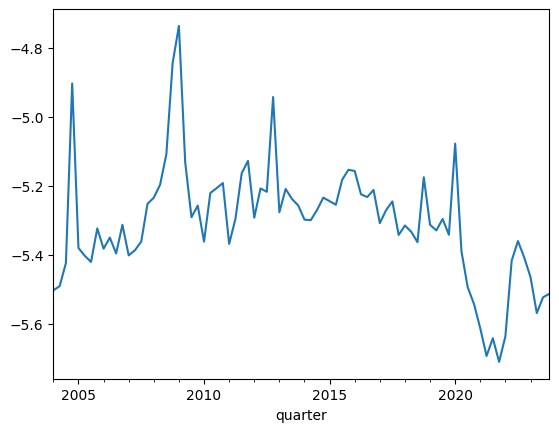

In [16]:
log_DP.plot();

In [17]:
adfuller( log_DP )

(-3.899350432495223,
 0.0020396327695660645,
 0,
 79,
 {'1%': -3.5159766913976376,
  '5%': -2.898885703483903,
  '10%': -2.5866935058484217},
 -97.78166666190316)

In [18]:
kpss( log_DP )

(0.5481570993815461,
 0.030820473112264386,
 4,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Conclusion: The ADF test rejects the null hypothesis that the series has a unit root, in favor of the alternative that it is stationary. But, the KPSS test can also reject the null hypothesis that the series is stationary, in favor of the alternative that it has a unit root. There is no guarantee in practice that the tests will give a consistent message. 

It is not surprising that the picture is unclear for this particular series. The literature has been debating for decades whether the dividend yield for stocks is stationary or not. Either way would have some very important implications for forecasting the overall stock market. But if the ratio is stationary, it appears to revert to its target very slowly (and that target itself may be moving over time). So even after decades of investigation, the data still don't clearly speak to one conclusion or the other.

#### 6. Match the last ADF test by hand:

Referring to the ADF test involving the log of dividends, the computer chose 4 lags as the appropriate amount. So if $y_t$ represents the log dividend amount at time $t$, then the regression we want to run is of $\Delta y_t$ on $y_{t-1}$ with 4 lags of $\Delta y_t$. The code is below. 
In the regression output, the ADF test statistic appears under the column "t", in the row labeled log_DP.shift(). This is the $t$-value for the regression coefficient on $y_{t-1}$. 

Although the $t$-value matches the ADF test statistic, we cannot use the $p$-value sitting right next to it as part of our ADF test. The $p$-value in the table is testing whether the regression coefficient on $y_{t-1}$ is different from zero, under the null hypothesis that *everything* in the regression is stationary. In this case our null hypothesis is that $y$ has a unit root, so the sampling distribution that we should use for our $p$-values is different from the one imagined by the standard regression formulas. Roughly speaking, it is a wider and skewed distribution. You can see that the $p$-value in the ADF test output above is much larger (about 10x larger) than the $p$-value in the regression output below.

In [19]:
ols("log_dividends.diff() ~ log_dividends.shift() \
    + log_dividends.diff().shift(1) \
    + log_dividends.diff().shift(2) \
    + log_dividends.diff().shift(3) \
    + log_dividends.diff().shift(4)",data=log_DP).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     log_dividends.diff()   R-squared:                       0.190
Model:                              OLS   Adj. R-squared:                  0.131
Method:                   Least Squares   F-statistic:                     3.239
Date:                  Wed, 20 Nov 2024   Prob (F-statistic):             0.0110
Time:                          15:39:02   Log-Likelihood:                 96.131
No. Observations:                    75   AIC:                            -180.3
Df Residuals:                        69   BIC:                            -166.4
Df Model:                             5                                         
Covariance Type:              nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.0210      0.049      0.425      0.672      -0.078       0.120
log_dividends.shift()            -0.0002      0.022     -0.011      0.991      -0.044       0.043
log_dividends.diff().shift(1)    -0.2445      0.113     -2.158      0.034      -0.470      -0.018
log_dividends.diff().shift(2)    -0.1606      0.099     -1.617      0.110      -0.359       0.038
log_dividends.diff().shift(3)    -0.1003      0.093     -1.082      0.283      -0.285       0.085
log_dividends.diff().shift(4)     0.1630      0.082      1.987      0.051      -0.001       0.327
==============================================================================
Omnibus:                       18.947   Durbin-Watson:                   2.072
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               62.840
Skew:                          -0.602   Prob(JB):                     2.26e-14
Kurtosis:                       7.320   Cond. No.                         48.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""